In [127]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DS Patient Matching Exploration

### EDA

In [214]:
df = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/ds_rec_hrs_modelling_20221109.csv')
df.head()

,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,has_incontinence,incontinence_type,incontinence_frequency,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,alert_oriented_self,alert_oriented_place,alert_oriented_day_time,best_in_class_assessor,assessor,reporting_current_hrs,reporting_rec_hrs,submitted_at,submitted_last_30d,age
0,2,1,3167,33,29,16,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,True,NaN,occasional_incontinence,NaN,2,1,2.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,False,Maria Plunkett,30.0,25.0,2020-12-20 15:26:06.000000,False,84
1,2,1,3167,6254,19,14,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,False,NaN,NaN,NaN,1,0,2.0,0.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Lenahan,15.0,15.0,2021-12-29 20:51:41.070885,False,84
2,2,2,3678,131,29,19,3.0,3.0,3.0,2.0,3.0,0.0,2.0,3.0,True,NaN,always_incontinent,NaN,0,0,2.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,False,Maria Plunkett,48.0,40.0,2021-01-12 23:58:03.877177,False,75
3,2,2,3678,9489,26,22,3.0,3.0,3.0,3.0,3.0,1.0,3.0,3.0,True,bladder_and_bowel,always_incontinent,NaN,0,1,1.0,0.0,1.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,False,Katy Slaven,48.0,48.0,2022-01-27 18:56:10.709471,False,75
4,2,4,3653,5642,19,14,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,True,NaN,occasional_incontinence,NaN,0,0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Maria Plunkett,49.0,40.0,2021-04-22 23:56:28.074340,False,52


### Modeling

In [215]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

In [216]:
categorical_features = [
    # slight boost
    'alert_oriented_self',
    'alert_oriented_place',
    'alert_oriented_day_time',

    # did not show any lift, low feature importance
    # 'has_incontinence',
    # 'incontinence_type',
    # 'incontinence_frequency',
]

cont_features = [
    # 'reporting_current_hrs',
    'payer_id',
    
    'age',
    # adls
    'transfer_bed_to_chair',
    'transfer_chair_to_standing',
    'mobility',
    'dressing',
    'bathing',
    'eating',
    'grooming',
    'toileting',
    'turn_change_position',
    # idls
    'calling_friends_and_family',
    'articulating_needs',
    'meal_prep',
    'shopping',
    'medication_management',
    'finances',
    'housework',
    'transportation',
    'driving',
    'daily_routine_decisions',
    'comprehension',
    'member_opinion',
    'cleaning',
    'laundry',
    'change_bed',
    'clean_kitchen',
    'clean_home',
    'medical_appointments',
    'work_school_socialize'
]
features = categorical_features + cont_features
target = 'reporting_rec_hrs'
# leave out payer id to keep it interpretable
categorical_feature_indexes = [i for i in range(len(categorical_features))] + [len(categorical_features)]

In [217]:
# encode_cat_features: HGBR requires categorical features to be 0-n_categories encoded
from sklearn.preprocessing import OrdinalEncoder
df[categorical_features] = OrdinalEncoder().fit_transform(df[categorical_features])

In [218]:
len(features)

33

In [219]:
df[features].head()

,alert_oriented_self,alert_oriented_place,alert_oriented_day_time,payer_id,age,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize
0,1.0,1.0,0.0,2,84,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2,1,2.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,2,84,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,NaN,1,0,2.0,0.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.0,2,75,3.0,3.0,3.0,2.0,3.0,0.0,2.0,3.0,NaN,0,0,2.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0.0,0.0,2,75,3.0,3.0,3.0,3.0,3.0,1.0,3.0,3.0,NaN,0,1,1.0,0.0,1.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,2,52,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,NaN,0,0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Best in class assessor model

In [220]:
# drop na targets from training set
training_df = df.loc[~df[target].isna()]

test_df = training_df.loc[~training_df.submitted_last_30d.isna()]
test_df = test_df.loc[test_df.submitted_last_30d]

training_df = training_df.loc[training_df.best_in_class_assessor]

training_df = training_df.loc[~training_df.sfere_id.isin(test_df.sfere_id)]

# training_df = training_df.loc[training_df[target] > 0]
# training_df = training_df.loc[training_df[target] <= 40]

X_train = training_df[features]
y_train = training_df[target]

X_test = test_df[features]
y_test = test_df[target]
X_train.shape, X_test.shape

((1270, 33), (1353, 33))

In [221]:
est = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes).fit(X_train, y_train)
preds = est.predict(X_test)

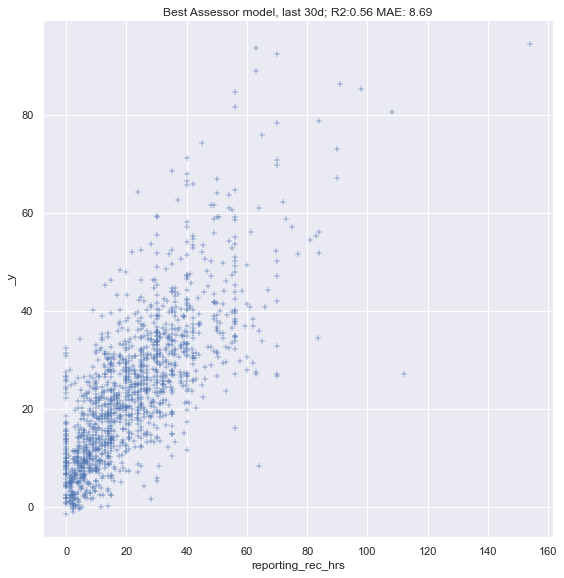

In [222]:
# preds vs rec
ax = sns.relplot(x=y_test, y=preds, marker='+', height=8)
ax.set(title=f'Best Assessor model, last 30d; R2:{est.score(X_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - preds)):.02f}')

### All assessor model

In [223]:
# drop na targets from training set
training_df = df.loc[~df[target].isna()]
# training_df = training_df.loc[training_df[target] > 0]
# training_df = training_df.loc[training_df[target] <= 40]

test_df = training_df.loc[~training_df.submitted_last_30d.isna()]
test_df = test_df.loc[test_df.submitted_last_30d]

training_df = training_df.loc[~training_df.sfere_id.isin(test_df.sfere_id)]


X_train = training_df[features]
y_train = training_df[target]

X_test = test_df[features]
y_test = test_df[target]
X_train.shape, X_test.shape

((11868, 33), (1353, 33))

In [224]:
est = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes).fit(X_train, y_train)
preds = est.predict(X_test)

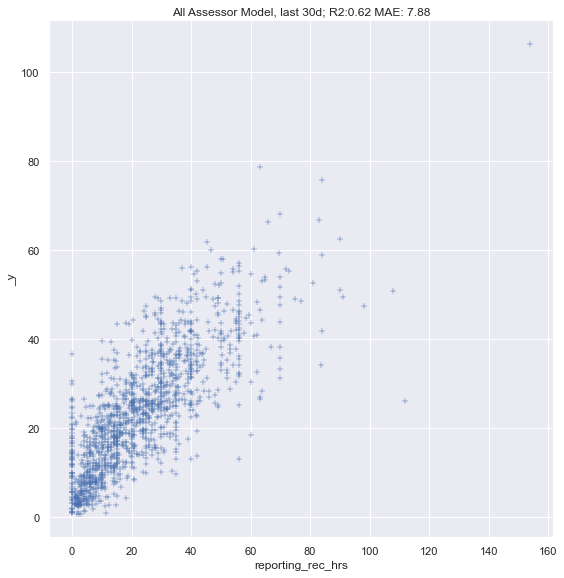

In [225]:
# preds vs rec
ax = sns.relplot(x=y_test, y=preds, marker='+', height=8)
ax.set(title=f'All Assessor Model, last 30d; R2:{est.score(X_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - preds)):.02f}')

In [226]:
tdf = test_df.assign(predicted_hours=preds, rec_minus_pred=test_df.reporting_rec_hrs - preds)
# ax = sns.relplot(data=tdf, x='reporting_rec_hrs', y='predicted_hours', marker='+', height=8)

In [227]:
tdf.rec_minus_pred.describe()

count    1353.000000
mean       -0.534184
std        10.935652
min       -36.547006
25%        -6.950413
50%        -1.442386
75%         4.365490
max        85.900019
Name: rec_minus_pred, dtype: float64

In [228]:
tdf.predicted_hours.describe()

count    1353.000000
mean       23.406801
std        13.574075
min         0.732965
25%        12.980103
50%        22.395481
75%        32.052937
max       106.273140
Name: predicted_hours, dtype: float64

In [237]:
std_by_payer = tdf.groupby('payer_id').rec_minus_pred.std()
std_by_payer = std_by_payer.rename('payer_error_std')
std_by_payer 

payer_id
2     12.808262
4      7.916811
5      7.488555
6     10.597528
8      4.616437
9     16.149382
12    12.603428
13     9.360875
Name: payer_error_std, dtype: float64

In [239]:
tdf = tdf.merge(std_by_payer, on='payer_id')
tdf = tdf.assign(error_std=tdf.rec_minus_pred / tdf.payer_error_std)
tdf.head()

,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,has_incontinence,incontinence_type,incontinence_frequency,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,alert_oriented_self,alert_oriented_place,alert_oriented_day_time,best_in_class_assessor,assessor,reporting_current_hrs,reporting_rec_hrs,submitted_at,submitted_last_30d,age,predicted_hours,rec_minus_pred,payer_error_std,error_std
0,2,24,3333,31599,10,4,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,False,NaN,NaN,NaN,0,0,1.0,1.0,0.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Heather Carlisle,20.0,15.0,2022-10-28 19:04:38.778010,True,33,18.765067,-3.765067,12.808262,-0.293956
1,2,34,1889,30462,13,7,0.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,False,NaN,NaN,NaN,0,0,2.0,0.0,0.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,False,Erin Barnett,19.0,14.0,2022-10-24 21:07:51.239084,True,69,22.836255,-8.836255,12.808262,-0.689887
2,2,47,1162,30461,28,20,3.0,3.0,3.0,2.0,3.0,0.0,3.0,3.0,False,NaN,NaN,NaN,0,0,2.0,2.0,0.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,24.0,24.0,2022-10-19 17:35:54.498831,True,60,41.702323,-17.702323,12.808262,-1.382102
3,2,57,1027,29546,17,12,0.0,0.0,0.0,2.0,2.0,2.0,3.0,3.0,True,bladder_and_bowel,always_incontinent,NaN,0,0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,False,Erin Barnett,45.0,45.0,2022-10-18 22:12:32.596928,True,31,37.729708,7.270292,12.808262,0.567625
4,2,61,318,29148,29,18,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,False,NaN,NaN,NaN,2,0,1.0,1.0,2.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,56.0,56.0,2022-10-14 21:47:30.603627,True,65,36.151015,19.848985,12.808262,1.549702


In [243]:
cols = ['payer_id', 'patient_id', 'analytics_member_id', 'sfere_id',
       'reporting_current_hrs', 'reporting_rec_hrs',
       'predicted_hours', 'rec_minus_pred', 'payer_error_std', 'error_std',
       'total_impairment_sum', 'adl_impairment_sum', 'transfer_bed_to_chair',
       'transfer_chair_to_standing', 'mobility', 'dressing', 'bathing',
       'eating', 'grooming', 'toileting', 'has_incontinence',
       'incontinence_type', 'incontinence_frequency', 'turn_change_position',
       'calling_friends_and_family', 'articulating_needs', 'meal_prep',
       'shopping', 'medication_management', 'finances', 'housework',
       'transportation', 'driving', 'daily_routine_decisions', 'comprehension',
       'member_opinion', 'cleaning', 'laundry', 'change_bed', 'clean_kitchen',
       'clean_home', 'medical_appointments', 'work_school_socialize',
       'alert_oriented_self', 'alert_oriented_place',
       'alert_oriented_day_time', 'best_in_class_assessor', 'assessor',
        'submitted_at', 'submitted_last_30d', 'age']

# tdf[cols].to_csv('./data/recomended_hours_model_alert_features_20221109.csv', index=False)

In [242]:
# sns.histplot(x=tdf.predicted_hours)
# sns.histplot(x=tdf.rec_minus_pred)

In [232]:
# tdf.to_csv('./data/recomended_hours_model_alert_features_20221109.csv', index=False)
# ax.savefig('/Users/bp/Downloads/recomended_hours_model.png')
# training_df.to_csv('./data/recomended_hours_model_training_data.csv', index=False)

### Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(est, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

### Tuning

In [ ]:
parameters = {
    'max_iter': [1000],
    'max_depth': [3,5,20,25],
    'min_samples_leaf': [10, 20, 50, 75, 100],
    'l2_regularization': [0, .1, .5]
}
parameters

In [ ]:
est = HistGradientBoostingRegressor(categorical_features=[0])

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

clf = HalvingGridSearchCV(est, parameters, factor=2, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)

clf.best_score_, clf.best_params_

### Compare to DL

In [256]:
lm_preds = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/ds_hrs_lm_sfere_preds_2.csv')
print(lm_preds.shape[0])
lm_preds.head()

1106


,sfere_id,pred
0,29581,20.218750
1,30246,26.859375
2,30670,34.531250
3,29249,26.187500
4,29553,17.203125


In [257]:
comb = tdf.merge(lm_preds, on='sfere_id')
print(comb.shape[0])
comb.head() 

823


,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,has_incontinence,incontinence_type,incontinence_frequency,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,alert_oriented_self,alert_oriented_place,alert_oriented_day_time,best_in_class_assessor,assessor,reporting_current_hrs,reporting_rec_hrs,submitted_at,submitted_last_30d,age,predicted_hours,rec_minus_pred,payer_error_std,error_std,pred
0,2,34,1889,30462,13,7,0.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,False,NaN,NaN,NaN,0,0,2.0,0.0,0.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,False,Erin Barnett,19.0,14.0,2022-10-24 21:07:51.239084,True,69,22.836255,-8.836255,12.808262,-0.689887,23.390625
1,2,47,1162,30461,28,20,3.0,3.0,3.0,2.0,3.0,0.0,3.0,3.0,False,NaN,NaN,NaN,0,0,2.0,2.0,0.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,24.0,24.0,2022-10-19 17:35:54.498831,True,60,41.702323,-17.702323,12.808262,-1.382102,24.546875
2,2,57,1027,29546,17,12,0.0,0.0,0.0,2.0,2.0,2.0,3.0,3.0,True,bladder_and_bowel,always_incontinent,NaN,0,0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,False,Erin Barnett,45.0,45.0,2022-10-18 22:12:32.596928,True,31,37.729708,7.270292,12.808262,0.567625,37.718750
3,2,61,318,29148,29,18,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,False,NaN,NaN,NaN,2,0,1.0,1.0,2.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,56.0,56.0,2022-10-14 21:47:30.603627,True,65,36.151015,19.848985,12.808262,1.549702,54.031250
4,2,88,2256,28947,20,6,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,False,NaN,NaN,NaN,0,0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,34.0,31.0,2022-10-11 15:01:07.105769,True,61,29.140169,1.859831,12.808262,0.145206,25.218750


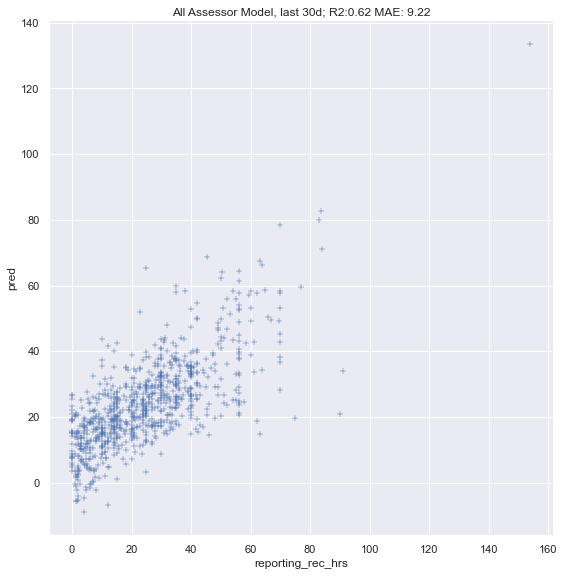

In [269]:
ax = sns.relplot(data=comb, x='reporting_rec_hrs', y='pred', marker='+', height=8)
ax.set(title=f'All Assessor Model, last 30d; R2:{est.score(X_test, y_test):.02f} MAE: {np.mean(np.abs(comb.reporting_rec_hrs - comb.pred)):.02f}')

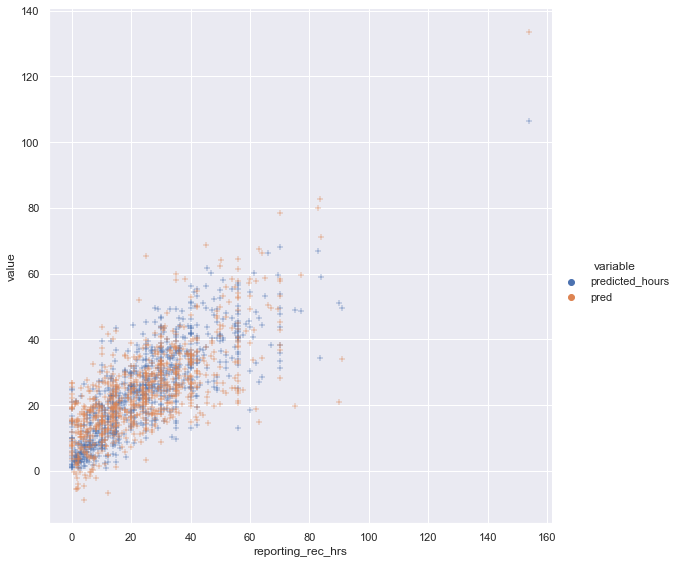

In [259]:
melted = pd.melt(comb, id_vars=['reporting_rec_hrs'], value_vars=['predicted_hours', 'pred'])
ax = sns.relplot(data=melted, x='reporting_rec_hrs', y='value', hue='variable', marker='+', height=8)

In [262]:
comb = comb.assign(ensemble=comb.predicted_hours * .5 + comb.pred * .5)

In [263]:
comb = comb.assign(rec_minus_ensemble=comb.reporting_rec_hrs - comb.ensemble)

In [267]:
comb[['rec_minus_ensemble', 'rec_minus_pred']].abs().mean()

rec_minus_ensemble    7.338477
rec_minus_pred        7.674286
dtype: float64

### Check out embeddings

In [273]:
emb = pd.read_csv('data/ds_hrs_lm_sfere_encodings_20221116.csv')

In [274]:
emb.head()

,sfere_id,encoding
0,29581,"[0.8835988640785217, 0.9973404407501221, 0.923..."
1,30246,"[0.3783913552761078, 0.9992464780807495, 0.998..."
2,30670,"[0.252015084028244, 0.9955561757087708, 0.9047..."
3,29249,"[0.262898713350296, 0.9745723009109497, 0.9780..."
4,29553,"[0.9917703866958618, 0.9752515554428101, 0.999..."


In [275]:
comb = comb.merge(emb, on='sfere_id')
comb.head()

,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,has_incontinence,incontinence_type,incontinence_frequency,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,alert_oriented_self,alert_oriented_place,alert_oriented_day_time,best_in_class_assessor,assessor,reporting_current_hrs,reporting_rec_hrs,submitted_at,submitted_last_30d,age,predicted_hours,rec_minus_pred,payer_error_std,error_std,pred,ensemble,rec_minus_ensemble,encoding
0,2,34,1889,30462,13,7,0.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,False,NaN,NaN,NaN,0,0,2.0,0.0,0.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,False,Erin Barnett,19.0,14.0,2022-10-24 21:07:51.239084,True,69,22.836255,-8.836255,12.808262,-0.689887,23.390625,23.113440,-9.113440,"[0.9942108392715454, 0.9220023155212402, 0.214..."
1,2,47,1162,30461,28,20,3.0,3.0,3.0,2.0,3.0,0.0,3.0,3.0,False,NaN,NaN,NaN,0,0,2.0,2.0,0.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,24.0,24.0,2022-10-19 17:35:54.498831,True,60,41.702323,-17.702323,12.808262,-1.382102,24.546875,33.124599,-9.124599,"[0.949133574962616, 0.9868451356887817, 0.9629..."
2,2,57,1027,29546,17,12,0.0,0.0,0.0,2.0,2.0,2.0,3.0,3.0,True,bladder_and_bowel,always_incontinent,NaN,0,0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,False,Erin Barnett,45.0,45.0,2022-10-18 22:12:32.596928,True,31,37.729708,7.270292,12.808262,0.567625,37.718750,37.724229,7.275771,"[0.459722638130188, 0.9735075831413269, 0.3561..."
3,2,61,318,29148,29,18,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,False,NaN,NaN,NaN,2,0,1.0,1.0,2.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,56.0,56.0,2022-10-14 21:47:30.603627,True,65,36.151015,19.848985,12.808262,1.549702,54.031250,45.091132,10.908868,"[0.9144882559776306, 0.7489809393882751, -0.32..."
4,2,88,2256,28947,20,6,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,False,NaN,NaN,NaN,0,0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,34.0,31.0,2022-10-11 15:01:07.105769,True,61,29.140169,1.859831,12.808262,0.145206,25.218750,27.179460,3.820540,"[0.9961888194084167, 0.9965144991874695, 0.253..."


In [290]:
comb.encoding.dtype
a = [1,2,3]
b = np.array(a)
b

array([1, 2, 3])

In [291]:
# need to transform list str into actual list
import ast
comb.encoding = comb.encoding.apply(ast.literal_eval)
comb.encoding = comb.encoding.apply(np.array)

In [303]:
vectors = np.zeros((comb.shape[0], 400))
for i, r in enumerate(comb.encoding):
    vectors[i] = r

In [306]:
from scipy.spatial import distance

In [317]:
target = comb.encoding.values[1]
# distances = distance.cdist([target], vectors, "cosine")[0]
distances = distance.cdist([target], vectors, "euclidean")[0]
min_index = np.argmin(distances)
min_distance = distances[min_index]
# print("Most similar vector to target is index %s with %s" % (max_index, max_similarity))

In [318]:
sim_idx = [si for si in np.argsort(distances)[0:11]]
comb.loc[sim_idx]

,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,has_incontinence,incontinence_type,incontinence_frequency,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,alert_oriented_self,alert_oriented_place,alert_oriented_day_time,best_in_class_assessor,assessor,reporting_current_hrs,reporting_rec_hrs,submitted_at,submitted_last_30d,age,predicted_hours,rec_minus_pred,payer_error_std,error_std,pred,ensemble,rec_minus_ensemble,encoding
1,2,47,1162,30461,28,20,3.0,3.0,3.0,2.0,3.0,0.0,3.0,3.0,False,NaN,NaN,NaN,0,0,2.0,2.0,0.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,24.00,24.00,2022-10-19 17:35:54.498831,True,60,41.702323,-17.702323,12.808262,-1.382102,24.546875,33.124599,-9.124599,"[0.949133574962616, 0.9868451356887817, 0.9629..."
154,4,25940,975057,29452,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,NaN,NaN,NaN,0,0,0.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,True,Billi Jo Ehrenberger,0.00,0.00,2022-10-11 20:54:11.511235,True,78,2.128920,-2.128920,7.916811,-0.268911,7.523438,4.826179,-4.826179,"[0.7684851884841919, 0.911194920539856, 0.9983..."
73,2,10072,2575,29149,6,2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,False,NaN,NaN,NaN,0,0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,20.00,15.00,2022-10-14 13:35:13.148114,True,87,12.193093,2.806907,12.808262,0.219148,25.718750,18.955921,-3.955921,"[0.8190751075744629, 0.9964675903320312, 0.990..."
393,6,11604,273540,28966,20,14,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,True,bladder_and_bowel,always_incontinent,NaN,0,0,1.0,1.0,0.0,1.0,NaN,1.0,NaN,0.0,0.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Barnett,24.75,20.75,2022-10-12 22:07:36.406598,True,60,31.211392,-10.461392,10.597528,-0.987154,24.812500,28.011946,-7.261946,"[0.8961284756660461, 0.9924485087394714, 0.995..."
633,9,20363,319046,29927,21,16,3.0,3.0,3.0,2.0,2.0,0.0,0.0,3.0,True,bladder,always_incontinent,NaN,0,0,2.0,0.0,0.0,0.0,2.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,True,Patricia Gilmore,91.00,50.00,2022-10-13 12:29:31.375985,True,85,41.138447,8.861553,16.149382,0.548724,41.125000,41.131724,8.868276,"[0.9802858233451843, 0.9984678030014038, 0.998..."
103,2,46359,268509,30121,20,14,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,True,bladder,always_incontinent,NaN,0,0,2.0,0.0,2.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,False,Erin Barnett,42.00,39.00,2022-10-19 17:14:11.774452,True,95,43.923776,-4.923776,12.808262,-0.384422,34.031250,38.977513,0.022487,"[0.5143184661865234, 0.8865538835525513, 0.952..."
469,6,50216,1016385,29489,14,7,0.0,0.0,2.0,2.0,1.0,0.0,2.0,0.0,True,bladder,occasional_incontinence,NaN,0,0,1.0,1.0,1.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Heather Carlisle,25.00,23.00,2022-10-25 18:01:04.095481,True,69,21.744372,1.255628,10.597528,0.118483,34.968750,28.356561,-5.356561,"[0.9854680895805359, 0.9963675737380981, 0.999..."
591,8,22743,533072,27930,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,bladder,nighttime_incontinence,NaN,0,0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Darlene Foust,3.45,3.05,2022-10-17 18:48:38.541240,True,67,2.608022,0.441978,4.616437,0.095740,11.296875,6.952448,-3.902448,"[0.8409342169761658, 0.9967057704925537, 0.999..."
205,4,29174,973650,29304,21,18,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,True,bladder,always_incontinent,NaN,0,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,True,Karen Kruse,10.00,7.00,2022-10-10 20:31:21.378351,True,99,9.456863,-2.456863,7.

### Reduce dimensions of emb to feed to boosted tree model

In [323]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(vectors)

PCA(n_components=2)

In [325]:
xy = pca.transform(vectors)
xy

array([[ 0.0157467 , -1.61377497],
       [-3.33120173,  0.08162128],
       [ 1.68982654, -0.39121864],
       ...,
       [ 3.2833535 , -0.7363643 ],
       [-0.46750189, -0.36353283],
       [-3.04949082,  0.56409357]])

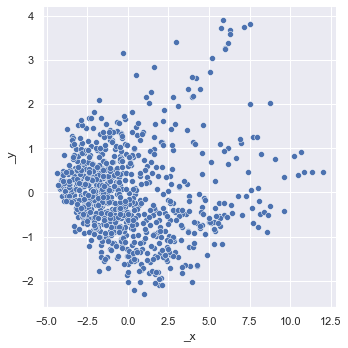

In [326]:
sns.relplot(x=xy[:, 0], y=xy[:,1])

### Look at similarity based just on adl distances